# Thyroid Analysis

## Imports

#### pandas

In [25]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix

#### matplotlib

In [26]:
import matplotlib.pyplot as plt

# do plotting inline instead of in a separate window
%matplotlib inline

#### sklearn

In [27]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
# import the performance metrics library
from sklearn import metrics

#### numpy

In [28]:
import numpy as np

## Load Data

In [29]:
data_path = "thyroid_data\\allhypo.data"
names = ['age',                          # continuous
         'sex',                          # M, F
         'on_thyroxine',                 # f, t
         'query_on_thyroxine',           # f, t
         'on_antithyroid_medication',    # f, t
         'sick',                         # f, t
         'pregnant',                     # f, t
         'thyroid_surgery',              # f, t
         'I131_treatment',               # f, t
         'query_hypothyroid',            # f, t
         'query_hyperthyroid',           # f, t
         'lithium',                      # f, t
         'goitre',                       # f, t
         'tumor',                        # f, t
         'hypopituitary',                # f, t
         'psych',                        # f, t
         'TSH_measured',                 # f, t
         'TSH',                          # continuous, ?
         'T3_measured',                  # f, t
         'T3',                           # continuous, ?
         'TT4_measured',                 # f, t
         'TT4',                          # continuous, ?
         'T4U_measured',                 # f, t
         'T4U',                          # continuous, ?
         'FTI_measured',                 # f, t
         'FTI',                          # continuous, ?
         'TBG_measured',                 # f, t
         'TBG',                          # continuous, ?
         'referral_source',              # WEST, STMW, SVHC, SVI, SVHD, other
         'diagnosis']                    # negative, compensated hypothyroid
dataset = pd.read_csv(data_path, names=names)

## Format Data

#### Fix diagnosis column

In [30]:
# Remove the patient ID
dataset['diagnosis'] = dataset['diagnosis'].map(lambda x: x.split('.|')[0])

# Remove the "Consistent with" aspect of diagnosis
# dataset['diagnosis'] = dataset['diagnosis'].map(lambda x: x.split('|')[1] if '|' in x else x)

#### Mapping strings to ints

In [31]:
# TRUE / FALSE => 1 / 0
map_dict = { 't': 1, 'f': 0}
indices = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
           'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
           'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured']
for index in indices:
    dataset[index] = dataset[index].map(map_dict)
    
dataset['sex'] = dataset['sex'].map({ 'F': 0, 'M': 1 })

# NOTE(david): This should be edited for extensibility
map_dict = {
    "-":    0,
    "A":    1,
    "AK":   2,
    "B":    3,
    "C":    4,
    "D":    5,
    "E":    6,
    "F":    7,
    "FK":   8,
    "G":    9,
    "GI":   10,
    "GK":   11,
    "GKJ":  12,
    "I":    13,
    "J":    14,
    "K":    15,
    "KJ":   16,
    "L":    17,
    "LJ":   18,
    "M":    19,
    "MI":   20,
    "MK":   21,
    "N":    22,
    "O":    23,
    "OI":   24,
    "P":    25,
    "Q":    26,
    "R":    27,
    "S":    28
}
diagnosis_map = {
    'negative'               : 0,
    'compensated hypothyroid': 1,
    'secondary hypothyroid'    : 2,
    'primary hypothyroid'  : 3
}
dataset['diagnosis'] = dataset['diagnosis'].map(diagnosis_map)
dataset = dataset[np.isfinite(dataset['sex'])]

dataset = dataset[(dataset.diagnosis != 2)]

#### Delete columns

In [32]:
# These are deleted since only 349 instances have information for TBG
del dataset['TBG_measured']
del dataset['TBG']

# Delete these columns since they're redundant
del dataset['TSH_measured']
del dataset['T3_measured']
del dataset['TT4_measured']
del dataset['T4U_measured']
del dataset['FTI_measured']

# These columns aren't relevant to this application at the moment.
# NOTE(david): This may need to be changed in the future.
del dataset['on_thyroxine']
del dataset['query_on_thyroxine']
del dataset['on_antithyroid_medication']
del dataset['sick']
del dataset['pregnant']
del dataset['thyroid_surgery']
del dataset['I131_treatment']
del dataset['query_hypothyroid']
del dataset['goitre']
del dataset['tumor']
del dataset['hypopituitary']
del dataset['psych']
del dataset['query_hyperthyroid']
del dataset['lithium']

# Useless field for this application
del dataset['referral_source']

#### Fix Missing cell data

In [33]:
indices = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
# Replace missing data with column mean
for index in indices:
    dataset[index] = dataset[index].map(lambda x: float(x) if x != '?' else x)
    mean = dataset[dataset[index] != '?'][index].mean()
    dataset[index] = dataset[index].map(lambda x: mean if x == '?' else x)

#### Summarize Data Pre-Filter

n-highest
               sex          TSH           T3          TT4          T4U  \
count  2688.000000  2688.000000  2688.000000  2688.000000  2688.000000   
mean      0.319568     4.516525     2.021435   109.124563     0.998283   
std       0.466396    18.640172     0.732484    34.216604     0.184436   
min       0.000000     0.005000     0.050000     2.000000     0.310000   
25%       0.000000     0.590000     1.700000    89.000000     0.890000   
50%       0.000000     1.600000     2.021435   107.000000     0.998283   
75%       1.000000     3.700000     2.200000   123.000000     1.070000   
max       1.000000   478.000000    10.600000   430.000000     2.120000   

               FTI    diagnosis  
count  2688.000000  2688.000000  
mean    110.730527     0.122396  
std      30.795813     0.491359  
min       2.000000     0.000000  
25%      95.000000     0.000000  
50%     110.000000     0.000000  
75%     122.000000     0.000000  
max     395.000000     3.000000  

Distribution Aft

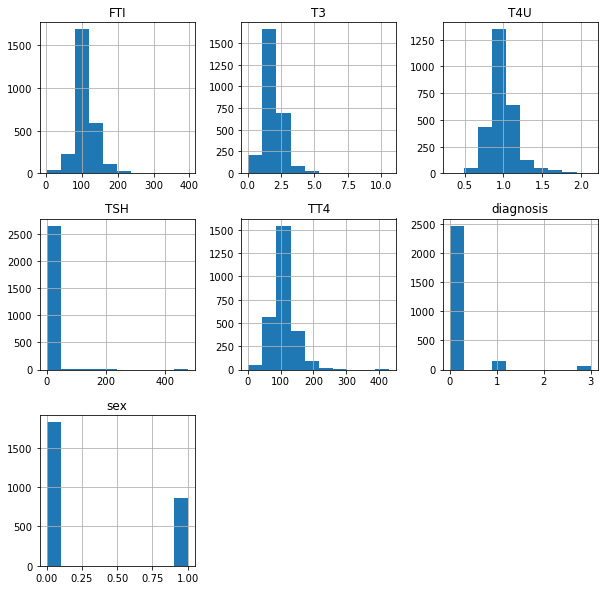

In [34]:
# print("description")
# print(dataset.describe())
print("n-highest")
# dataset.sort_values('age', ascending=False)[:10]
# dataset.sort_values('TSH', ascending=False)[:10]
# dataset.sort_values('T3',  ascending=False)[:10]
# dataset.sort_values('TT4', ascending=False)[:10]
# dataset.sort_values('T4U', ascending=False)[:10]
dataset.sort_values('FTI', ascending=False)[:10]

print(dataset.describe())

print()
print('Distribution After:')
print('Negative: {}'.format(dataset[dataset.diagnosis == 0].size))
print('Compensated Hypothyroid: {}'.format(dataset[dataset.diagnosis == 1].size))
print('Secondary Hypothyroid: {}'.format(dataset[dataset.diagnosis == 2].size))
print('Primary Hypothyroid: {}'.format(dataset[dataset.diagnosis == 3].size))

dataset.hist(figsize=(10,10))
plt.show()

#### Remove Data Outliers

Distribution After:
Negative: 19680
Compensated Hypothyroid: 1192
Secondary Hypothyroid: 0
Primary Hypothyroid: 464


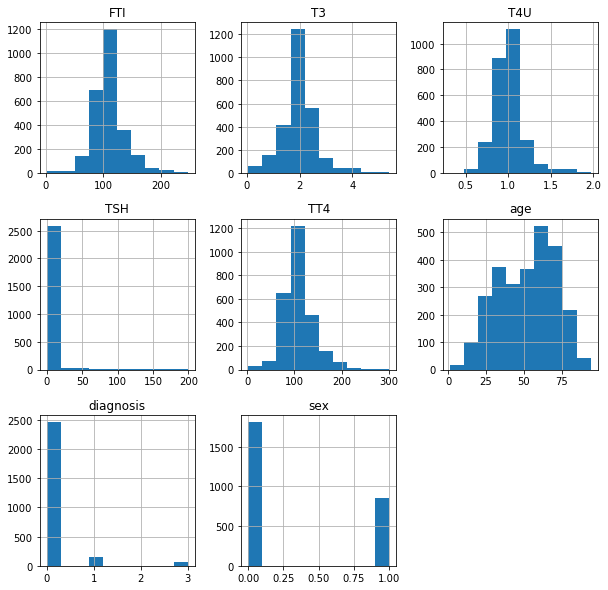

In [35]:
dataset = dataset[(dataset.FTI < 250)]
dataset = dataset[(dataset.T3  < 5.5)]
dataset = dataset[(dataset.T4U < 2)]
dataset = dataset[(dataset.TSH < 250)]
dataset = dataset[(dataset.TT4 < 320)]

dataset = dataset[(dataset.age != '?')]
dataset['age'] = dataset['age'].map(lambda x: float(x))
dataset = dataset[(dataset.age < 105)]

print('Distribution After:')
print('Negative: {}'.format(dataset[dataset.diagnosis == 0].size))
print('Compensated Hypothyroid: {}'.format(dataset[dataset.diagnosis == 1].size))
print('Secondary Hypothyroid: {}'.format(dataset[dataset.diagnosis == 2].size))
print('Primary Hypothyroid: {}'.format(dataset[dataset.diagnosis == 3].size))

dataset.hist(figsize=(10,10))
plt.show()

#### Filter Instances

In [36]:
for column in dataset:
    if column != 'diagnosis':
        dataset[column] = (dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

The diagnosis consists of a string of letters indicating diagnosed conditions.
A diagnosis "-" indicates no condition requiring comment.  A diagnosis of the
form "X|Y" is interpreted as "consistent with X, but more likely Y".  The
conditions are divided into groups where each group corresponds to a class of
comments.

		Letter	Diagnosis
		------	---------

	hyperthyroid conditions:

		A	hyperthyroid
		B	T3 toxic
		C	toxic goitre
		D	secondary toxic

	hypothyroid conditions:

		E	hypothyroid
		F	primary hypothyroid
		G	compensated hypothyroid
		H	secondary hypothyroid

	binding protein:

		I	increased binding protein
		J	decreased binding protein

	general health:

		K	concurrent non-thyroidal illness

	replacement therapy:

		L	consistent with replacement therapy
		M	underreplaced
		N	overreplaced

	antithyroid treatment:

		O	antithyroid drugs
		P	I131 treatment
		Q	surgery

	miscellaneous:

		R	discordant assay results
		S	elevated TBG
		T	elevated thyroid hormones

## Summarize Data

In [37]:
# del dataset['TT4']
print("Instances: {}, Columns: {}".format(dataset.shape[0], dataset.shape[1]))
print(dataset.head(20))

Instances: 2667, Columns: 8
         age  sex       TSH        T3       TT4       T4U       FTI  diagnosis
0   0.430108  0.0  0.006508  0.457944  0.411371  0.500000  0.436735          0
1   0.236559  0.0  0.020578  0.364486  0.334448  0.414628  0.443798          0
2   0.483871  1.0  0.004900  0.368493  0.357860  0.361446  0.481633          0
3   0.741935  0.0  0.000779  0.345794  0.578595  0.414628  0.443798          0
4   0.741935  0.0  0.003593  0.214953  0.197324  0.337349  0.277551          0
5   0.182796  0.0  0.000126  0.368493  0.605351  0.596386  0.567347          0
6   0.623656  0.0  0.022672  0.368493  0.234114  0.367470  0.310204          0
7   0.849462  0.0  0.011030  0.102804  0.260870  0.234940  0.461224          0
8   0.698925  0.0  0.002990  0.401869  0.404682  0.373494  0.530612          0
9   0.720430  1.0  0.012035  0.289720  0.270903  0.349398  0.371429          0
10  0.892473  0.0  0.005503  0.401869  0.377926  0.385542  0.485714          0
11  0.709677  0.0  0.000

In [38]:
dataset.corr()

,age,sex,TSH,T3,TT4,T4U,FTI,diagnosis
age,1.000000,-0.006665,-0.016618,-0.264562,-0.058046,-0.175766,0.048897,0.002905
sex,-0.006665,1.000000,-0.031956,-0.065330,-0.163097,-0.228542,-0.026704,-0.039245
TSH,-0.016618,-0.031956,1.000000,-0.204498,-0.320050,0.061708,-0.361632,0.690939
T3,-0.264562,-0.065330,-0.204498,1.000000,0.478905,0.453202,0.226965,-0.218217
TT4,-0.058046,-0.163097,-0.320050,0.478905,1.000000,0.452996,0.759568,-0.345874
T4U,-0.175766,-0.228542,0.061708,0.453202,0.452996,1.000000,-0.175587,0.042760
FTI,0.048897,-0.026704,-0.361632,0.226965,0.759568,-0.175587,1.000000,-0.383811
diagnosis,0.002905,-0.039245,0.690939,-0.218217,-0.345874,0.042760,-0.383811,1.000000


In [39]:
print( dataset.head())

        age  sex       TSH        T3       TT4       T4U       FTI  diagnosis
0  0.430108  0.0  0.006508  0.457944  0.411371  0.500000  0.436735          0
1  0.236559  0.0  0.020578  0.364486  0.334448  0.414628  0.443798          0
2  0.483871  1.0  0.004900  0.368493  0.357860  0.361446  0.481633          0
3  0.741935  0.0  0.000779  0.345794  0.578595  0.414628  0.443798          0
4  0.741935  0.0  0.003593  0.214953  0.197324  0.337349  0.277551          0


## Visualize

In [40]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.
    
    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
        
    Displays:
        matrix of correlation between columns.   Blue-cyan-yellow-red-darkred => less to more correlated
                                                 0 ------------------> 1
                                                 Expect a darkred line running from top left to bottom right
    """
    
    corr = df.corr()     # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)     # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)    # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)    # draw y tick marks

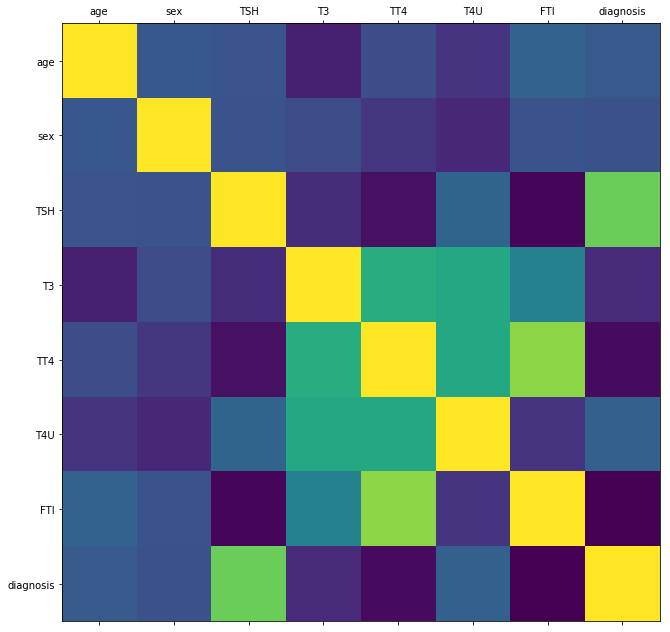

In [41]:
plot_corr(dataset)

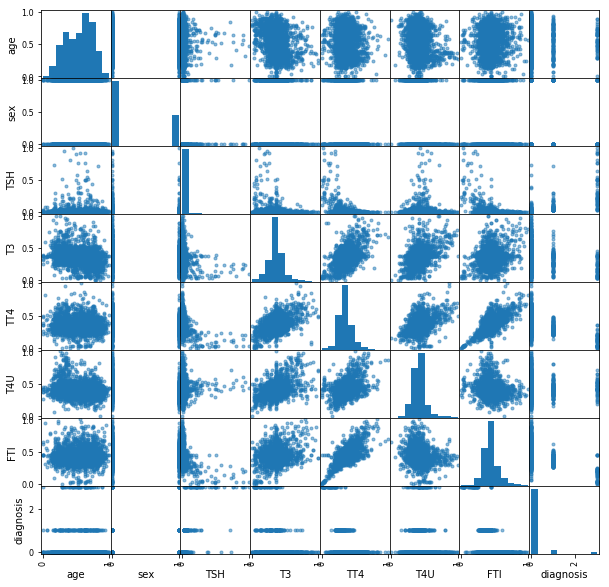

In [42]:
scatter_matrix(dataset,figsize=(10,10))
plt.show()

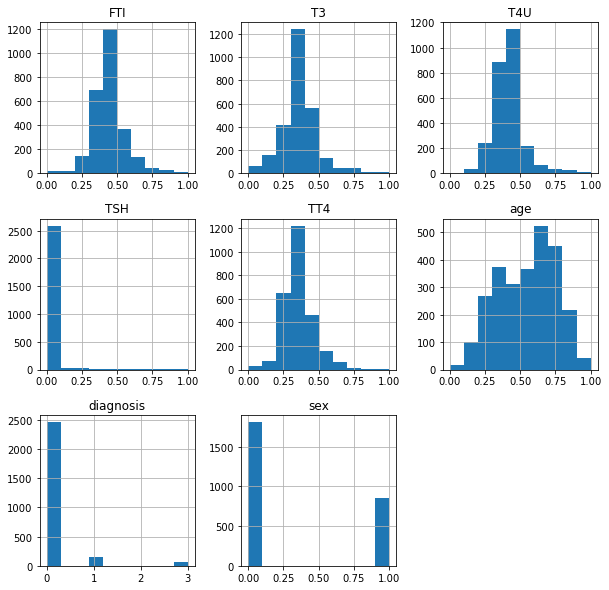

In [43]:
dataset.hist(figsize=(10,10))
plt.show()

## Evaluate Algorithms

#### Validation Set

In [44]:
# Split out validation dataset
array = dataset.values
X = array[:,0:7]
y = array[:,7]
test_size = 0.20
random_seed = 42
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_seed)

#### Verify an accurate split

In [45]:
print("Original Primary       : {0} ({1:0.2f}%)".format(len(dataset.loc[dataset['diagnosis'] == 3]), len(dataset.loc[dataset['diagnosis'] == 3])/len(dataset.index)*100))
print("Original Secondary     : {0} ({1:0.2f}%)".format(len(dataset.loc[dataset['diagnosis'] == 2]), len(dataset.loc[dataset['diagnosis'] == 2])/len(dataset.index)*100))
print("Original Compensated   : {0} ({1:0.2f}%)".format(len(dataset.loc[dataset['diagnosis'] == 1]), len(dataset.loc[dataset['diagnosis'] == 1])/len(dataset.index)*100))
print("Original False         : {0} ({1:0.2f}%)".format(len(dataset.loc[dataset['diagnosis'] == 0]), len(dataset.loc[dataset['diagnosis'] == 0])/len(dataset.index)*100))
print()
print("Training Primary       : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 3]), len(y_train[y_train[:] == 3])/len(y_train)*100))
print("Training Secondary     : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 2]), len(y_train[y_train[:] == 2])/len(y_train)*100))
print("Training Compensated   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), len(y_train[y_train[:] == 1])/len(y_train)*100))
print("Training False         : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), len(y_train[y_train[:] == 0])/len(y_train)*100))
print()
print("Test Primary           : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 3]), len(y_test[y_test[:] == 3])/len(y_test)*100))
print("Test Secondary         : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 2]), len(y_test[y_test[:] == 2])/len(y_test)*100))
print("Test Compensated       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), len(y_test[y_test[:] == 1])/len(y_test)*100))
print("Test Negative          : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), len(y_test[y_test[:] == 0])/len(y_test)*100))


#     'negative'               : 0,
#     'compensated hypothyroid': 1,
#     'secondary hypothyroid'    : 2,
#     'primary hypothyroid'  : 3

Original Primary       : 58 (2.17%)
Original Secondary     : 0 (0.00%)
Original Compensated   : 149 (5.59%)
Original False         : 2460 (92.24%)

Training Primary       : 47 (2.20%)
Training Secondary     : 0 (0.00%)
Training Compensated   : 115 (5.39%)
Training False         : 1971 (92.41%)

Test Primary           : 11 (2.06%)
Test Secondary         : 0 (0.00%)
Test Compensated       : 34 (6.37%)
Test Negative          : 489 (91.57%)


#### Test Harness

In [46]:
# Test options and evaluation metric
scoring = 'accuracy'
n_splits = 20

#### Build Models

### Logistic Regression

In [47]:
LR = LogisticRegressionCV(cv=10,
                        refit=True,
                        class_weight='balanced',
                        random_state=random_seed,
                        n_jobs=-1)
LR.fit(X_train, y_train)

LR_test = LR.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, LR_test)))
print(metrics.confusion_matrix(y_test, LR_test, labels=[1,0]))
print()
print("Classification Report")
print(metrics.classification_report(y_test, LR_test, labels=[1,0]))

Accuracy: 0.9682
[[ 24   3]
 [  4 482]]

Classification Report
             precision    recall  f1-score   support

          1       0.86      0.71      0.77        34
          0       0.99      0.99      0.99       489

avg / total       0.98      0.97      0.98       523



In [48]:
# Spot check algorithms
models = [
    ('LR', LogisticRegression(class_weight="balanced", random_state=42)),
    ('LR_CV', LogisticRegressionCV(cv=10,
                        refit=True,
                        class_weight='balanced',
                        random_state=random_seed,
                        n_jobs=-1)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('CART', DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ('NB', GaussianNB()),
    ('SVM', SVC(class_weight="balanced", random_state=42))
]

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=n_splits, random_state=random_seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("{}: %{:f} (%{:f})".format(name, cv_results.mean(), cv_results.std()))

LR: %0.939984 (%0.018869)
LR_CV: %0.968123 (%0.013040)
LDA: %0.936704 (%0.020302)


C:\Users\david\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


KNN: %0.933411 (%0.021206)
CART: %0.968577 (%0.013732)
NB: %0.942325 (%0.019730)
SVM: %0.713115 (%0.051229)


#### Select the Best Model

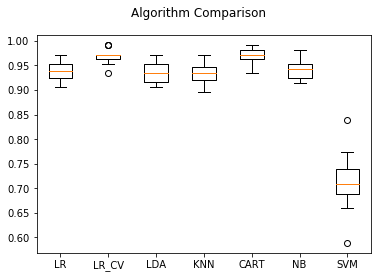

In [49]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Make Predictions

In [50]:
# Make predictions on validation dataset
cart = DecisionTreeClassifier(class_weight="balanced", random_state=42)
cart.fit(X_train, y_train)
predictions = cart.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.983146067416
[[485   3   1]
 [  5  29   0]
 [  0   0  11]]
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       489
        1.0       0.91      0.85      0.88        34
        3.0       0.92      1.00      0.96        11

avg / total       0.98      0.98      0.98       534

